In [58]:
### Imports
import os
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\Unmasking power\\UP codebase')
from statsmodels.stats.proportion import proportion_confint
import src.folders as folders
import src.power as power
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.rcParams.update({'font.family': 'arial'})
title_fontdict = {'fontsize': 16, 'fontweight': 'bold'}
axislabel_fontdict = {'fontsize': 14, 'fontweight': 'bold'}
ticklabel_fontsize = 12

dir_out=os.path.join(folders.exports, 'Prob CGR in CI')
def save_fig(fig, fname, dir_out=dir_out):
    for fileformat in ['png', 'svg']:
        fig.savefig(
            fname=os.path.join(dir_out, f'{fname}.{fileformat}'),
            bbox_inches='tight',
            format=fileformat,
            dpi=300,)

In [71]:
# ### Setup
n_trials = 300
sample = 500
draws = 2000

### Select one

trial_name = 'POP' # Psilocybin trial
n_match = 20
n_obs = 24
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
print(f'{trial_name} CGR CI: {(target_ciH+target_ciL)/2:.3f} [{target_ciL:.3f}, {target_ciH:.3f}]')

trial_name = 'Sloshower' # Psilocybin trial
n_match = 27
n_obs = 34
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
print(f'{trial_name} CGR CI: {(target_ciH+target_ciL)/2:.3f} [{target_ciL:.3f}, {target_ciH:.3f}]')

trial_name = 'Jelovac' # Ketamine vs depression
n_match = 38
n_obs = 60
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
print(f'{trial_name} CGR CI: {(target_ciH+target_ciL)/2:.3f}[{target_ciL:.3f}, {target_ciH:.3f}]')

trial_name = 'Lewis' # SSRI trial
n_match = (115+233)
n_obs = (115+152+52+233)
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
print(f'{trial_name} CGR CI: {(target_ciH+target_ciL)/2:.3f} [{target_ciL:.3f}, {target_ciH:.3f}]')

trial_name = 'Richard' # SSRI trial
n_match = (46+11)
n_obs = (46+11+18+22)
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
print(f'{trial_name} CGR CI: {(target_ciH+target_ciL)/2:.3f} [{target_ciL:.3f}, {target_ciH:.3f}]')

trial_name = 'Avery' # rTMS
n_match = (19+13)
n_obs = (63)
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
print(f'{trial_name} CGR CI: {(target_ciH+target_ciL)/2:.3f} [{target_ciL:.3f}, {target_ciH:.3f}]')


POP CGR CI: 0.833 [0.684, 0.982]
Sloshower CGR CI: 0.794 [0.658, 0.930]
Jelovac CGR CI: 0.633[0.511, 0.755]
Lewis CGR CI: 0.630 [0.590, 0.671]
Richard CGR CI: 0.588 [0.490, 0.686]
Avery CGR CI: 0.508 [0.384, 0.631]


Whats the probability that after n guesses, a random guesser would have a CGR within the experimental CI? 

In [60]:
### Calc p(random guessing yields CGR in target range | n observations)
# df_patientsData => only has CGR=0.5
df_patientsData=[]
for cgr in [0.5]: 
    cgr = round(cgr, 2)
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'CGR {cgr}', 
            n_trials = n_trials, 
            sample = sample, 
            params = [{
                'type': 'binaryguess',
                'arm_params':{
                    'C': {'cgr': cgr},
                    'T': {'cgr': cgr},},}]))       
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData = df_patientsData.rename(columns={'value': 'cgr',})    

### Calculate probability
n_succes = 0
for draw in range(0, draws):
    
    df_tmp = df_patientsData.sample(n=n_obs, replace=True)
    matches = (df_tmp['trt'] == df_tmp['guess_bin']).astype(int)
    cgr = matches.sum() / len(matches)

    if (cgr >= target_ciL) and (cgr <= target_ciH):
       n_succes += 1

print(f'For trial {trial_name} (n={n_obs}), p(CGR within CI | true CGR = 0.5): {round(n_succes/draws, 4)}')

For trial Avery (n=63), p(CGR within CI | true CGR = 0.5): 0.0655


Whats the probability that after n guesses, we have a CGR within the experimental CI as a function of the true CGR?

In [61]:
### Generate mock data
n_trials = 100
sample = 200

# df_patientsData => range of CGRs
cgrs = [round(float(cgr), 2) for cgr in np.arange(0, 1.01, 0.02)]
df_patientsData=[]
for cgr in cgrs:
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'{cgr}', 
            n_trials = n_trials, 
            sample = sample, 
            params = [{
                'type': 'binaryguess',
                'arm_params':{
                    'C': {'cgr': cgr},
                    'T': {'cgr': cgr},},}]))       
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData['cgr'] = pd.to_numeric(df_patientsData['scenario'], errors='coerce')
del df_patientsData['scenario']
df_patientsData = df_patientsData[['cgr','trial','pID','trt','guess_bin',]]
df_patientsData.head(3)

,cgr,trial,pID,trt,guess_bin
0,0.0,0,0,T,C
1,0.0,0,1,T,C
2,0.0,0,2,C,T


In [62]:
### Calculate p(inrange) as function of CGR - vectorized
target_ciL, target_ciH = proportion_confint(n_match, n_obs)
cgrs = df_patientsData.cgr.unique().tolist()
trials = df_patientsData.trial.unique().tolist()

rows = []
for cgr in cgrs:
    for trial in trials:
        
        df_tmp = df_patientsData.loc[
            (df_patientsData.cgr == cgr) & 
            (df_patientsData.trial == trial)]
        
        if len(df_tmp) == 0:
            continue
        
        # Precompute match array for all rows in this group
        match_arr = (df_tmp['trt'] == df_tmp['guess_bin']).values.astype(float)
        n_pool = len(match_arr)
        
        # Generate all random indices at once: (draws, n_obs)
        idx = np.random.randint(0, n_pool, size=(draws, n_obs))
        
        # Compute CGR for all draws at once
        cgr_samples = match_arr[idx].mean(axis=1)
        
        # Count how many fall in range
        n_inrange = ((cgr_samples >= target_ciL) & (cgr_samples <= target_ciH)).sum()
        
        row = {}
        row['cgr'] = cgr
        row['trial'] = trial
        row['p_inrange'] = round(n_inrange / draws, 4)
        rows.append(row)

df_inrange = pd.DataFrame(rows)

# For each trial, normalize probability
for trial in trials:
    
    # Probability mass function: values are discrete probabilities that sum to 1
    df_inrange.loc[df_inrange.trial==trial, 'p_inrange'] = df_inrange.loc[df_inrange.trial==trial, 'p_inrange']/df_inrange.loc[df_inrange.trial==trial, 'p_inrange'].sum()
        
    # Probability density function: Compare distributions with different CGR resolutions; 
    # peak heights are comparable
    # auc = np.trapezoid(
    #     x = df_inrange.loc[df_inrange.trial==trial, 'cgr'],
    #     y = df_inrange.loc[df_inrange.trial==trial, 'p_inrange'])
    # df_inrange.loc[df_inrange.trial==trial, 'p_inrange'] = \
    #     df_inrange.loc[df_inrange.trial==trial, 'p_inrange'] / (len(cgrs)*auc)
    # print(df_inrange.loc[df_inrange.trial==trial, 'p_inrange'].sum())

# Calculate the average p_inrange across trials
df_inrange_cgravg = df_inrange.groupby('cgr')['p_inrange'].mean().reset_index()
df_inrange_cgravg.columns = ['cgr', 'p_inrange']
df_inrange_cgravg.head(3)

,cgr,p_inrange
0,0.00,0.0
1,0.02,0.0
2,0.04,0.0


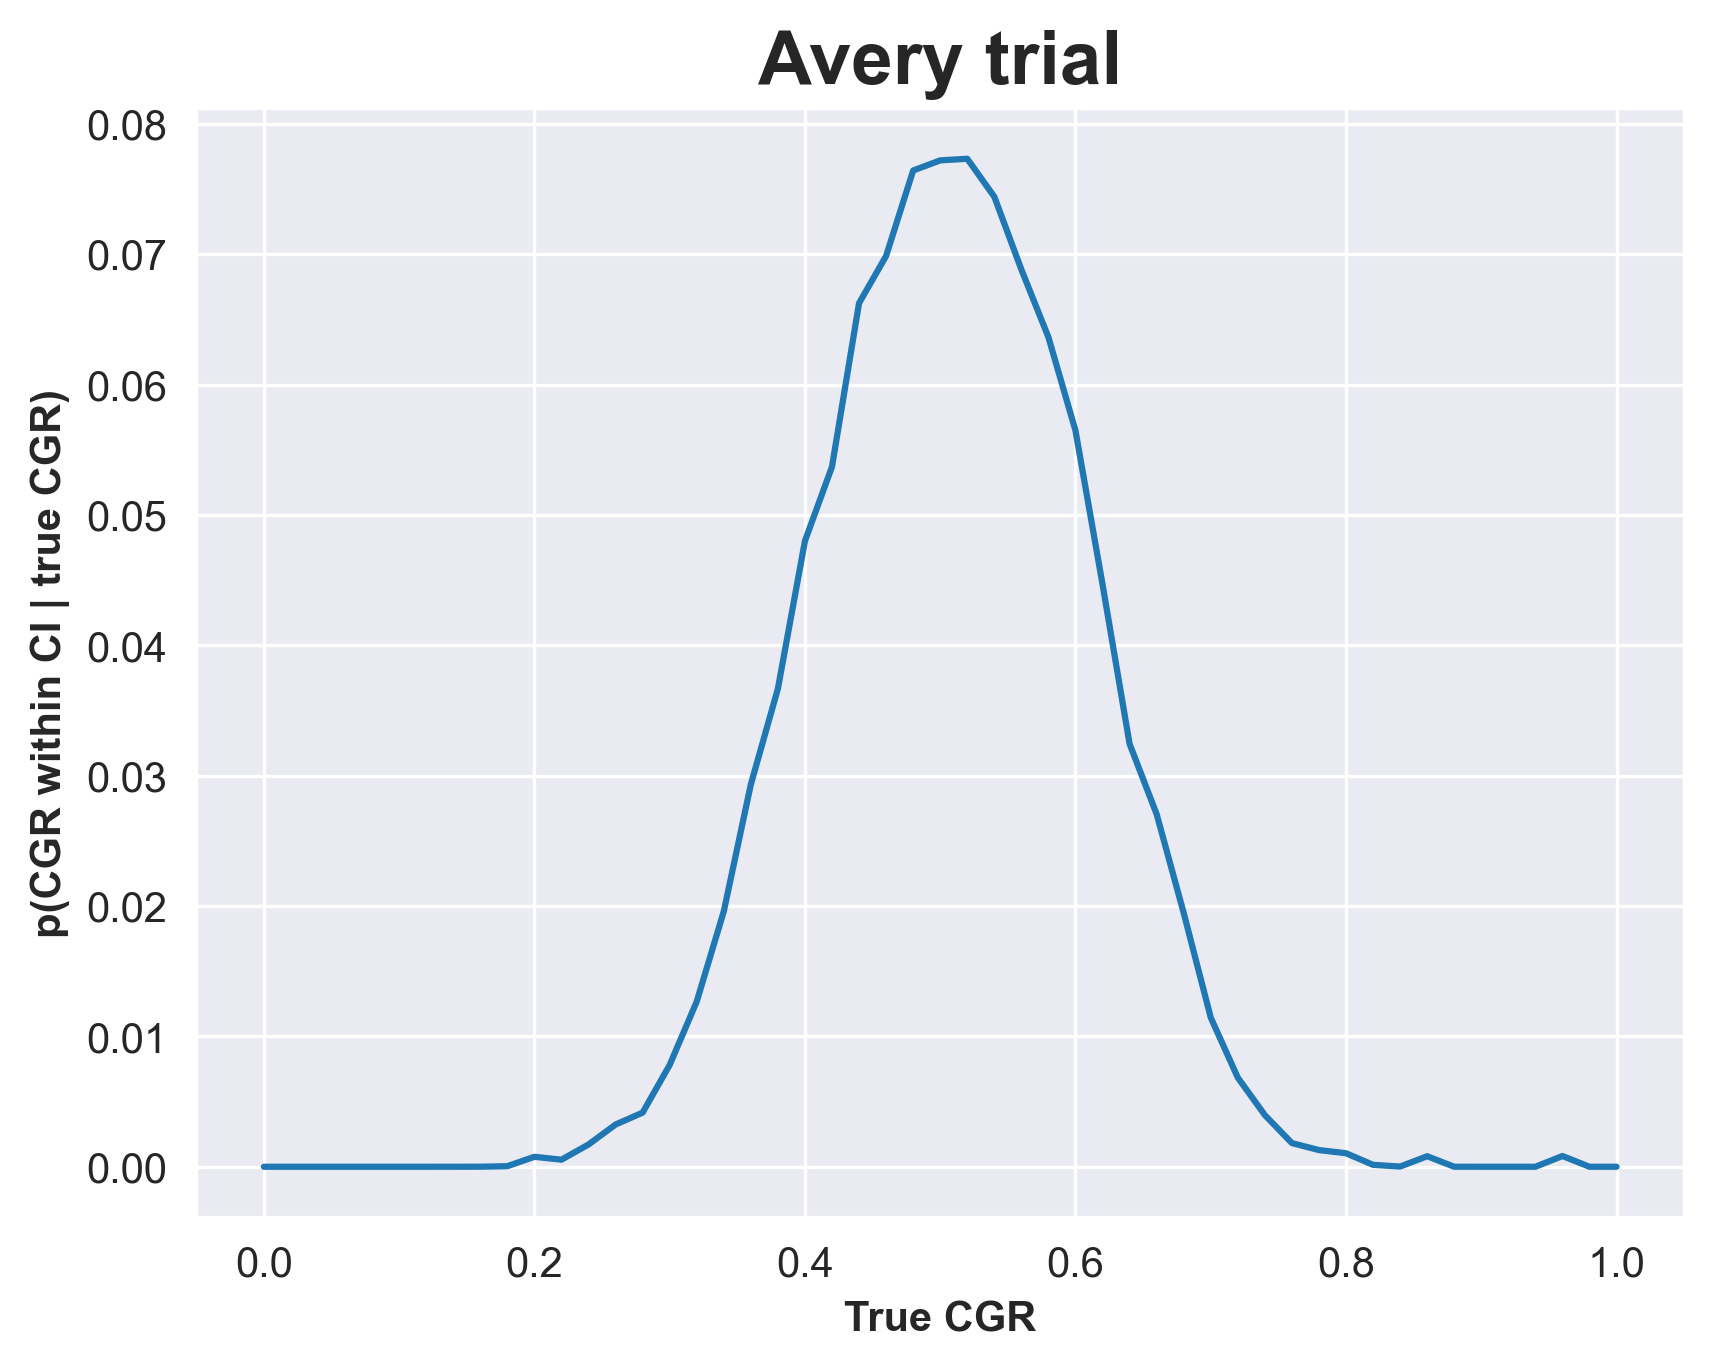

In [63]:
### Plot p(CGR within CI | true CGR)
fig, ax = plt.subplots()
sns.lineplot(
    data = df_inrange_cgravg,
    x = 'cgr', 
    y = 'p_inrange',
)

plt.title(f'{trial_name} trial', fontweight='bold', fontsize=18)
ax.set_xlabel('True CGR', fontweight='bold')
ax.set_ylabel('p(CGR within CI | true CGR)', fontweight='bold')
save_fig(fig, f'pdf_{trial_name}')
plt.show()

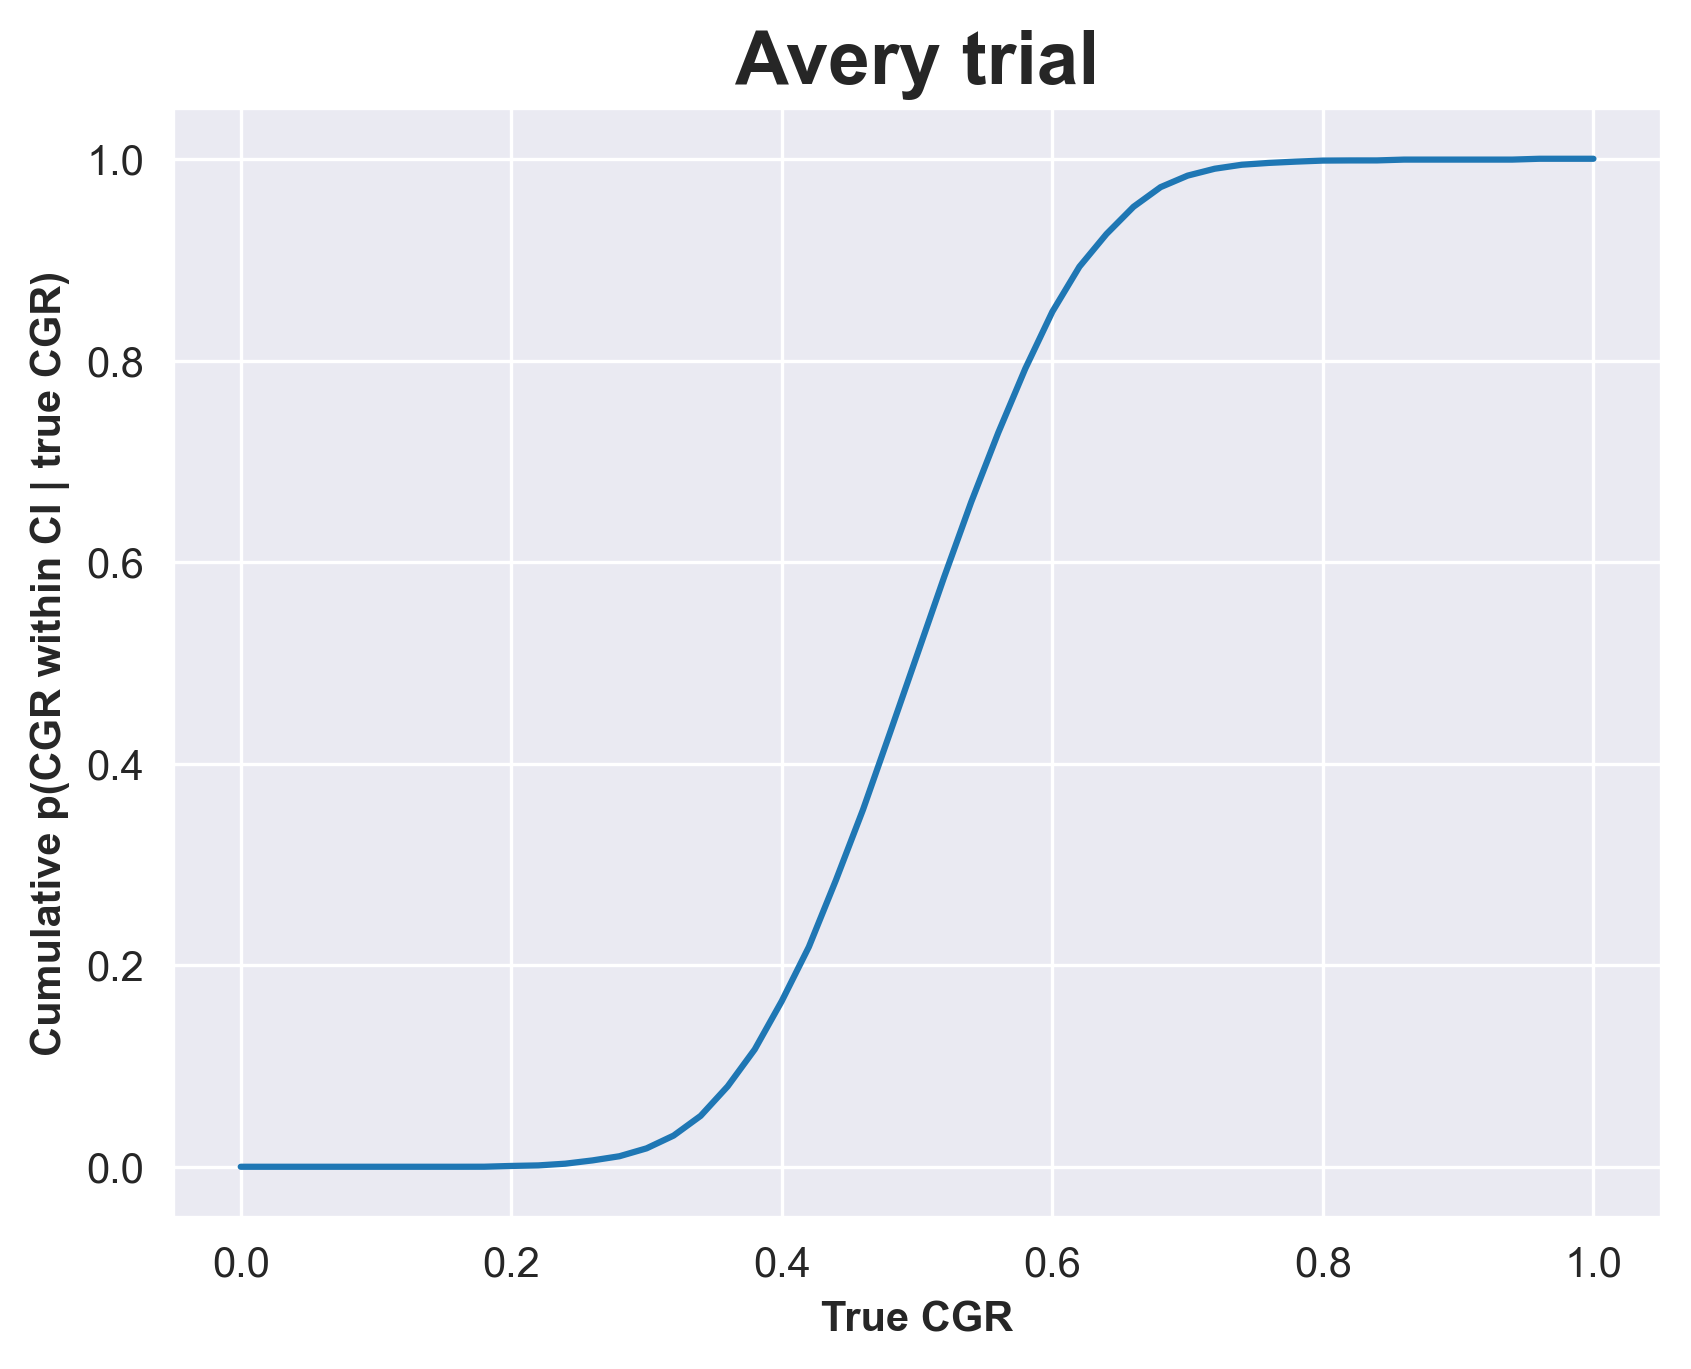

In [64]:
### Plot cumulative p(CGR within CI | true CGR)
df_inrange_cgravg['p_cumulative'] = df_inrange_cgravg['p_inrange'].cumsum()

fig, ax = plt.subplots()
sns.lineplot(
    data = df_inrange_cgravg,
    x = 'cgr', 
    y = 'p_cumulative',
)

plt.title(f'{trial_name} trial', fontweight='bold', fontsize=18)
ax.set_xlabel('True CGR', fontweight='bold')
ax.set_ylabel('Cumulative p(CGR within CI | true CGR)', fontweight='bold')
save_fig(fig, f'cumulative_{trial_name}')
plt.show()

In [65]:
### Output probabilities to dataframe
digits = 3

data = {
    'trial':
        [trial_name]*5,
    'definition': [
        'p(CGR in CI | true CGR in [0.0, 0.4])',
        'p(CGR in CI | true CGR in [0.41, 0.6])',
        'p(CGR in CI | true CGR in [0.61, 0.8])',
        'p(CGR in CI | true CGR in [0.81, 1.0])',
        'p(CGR in CI | true CGR not in [0.4, 0.6])'
    ],
    'masking_region': [
        'deception',
        'masked',
        'orange unmasked',
        'red unmasked',
        'unmasked'
    ],    
    'probability': [
        round(df_inrange_cgravg.loc[df_inrange_cgravg.cgr <= 0.4, 'p_inrange'].sum(), digits),
        round(df_inrange_cgravg.loc[(df_inrange_cgravg.cgr > 0.4) & (df_inrange_cgravg.cgr <= 0.6), 'p_inrange'].sum(), digits),
        round(df_inrange_cgravg.loc[(df_inrange_cgravg.cgr > 0.6) & (df_inrange_cgravg.cgr <= 0.8), 'p_inrange'].sum(), digits),
        round(df_inrange_cgravg.loc[df_inrange_cgravg.cgr > 0.8, 'p_inrange'].sum(), digits),
        round(df_inrange_cgravg.loc[~((df_inrange_cgravg.cgr > 0.4) & (df_inrange_cgravg.cgr <= 0.6)), 'p_inrange'].sum(), digits)
    ]
}

df_probs = pd.DataFrame(data)
df_probs.to_csv(os.path.join(dir_out, f'probs_{trial_name}.csv'), index=False)
df_probs

,trial,definition,masking_region,probability
0,Avery,"p(CGR in CI | true CGR in [0.0, 0.4])",deception,0.165
1,Avery,"p(CGR in CI | true CGR in [0.41, 0.6])",masked,0.684
2,Avery,"p(CGR in CI | true CGR in [0.61, 0.8])",orange unmasked,0.150
3,Avery,"p(CGR in CI | true CGR in [0.81, 1.0])",red unmasked,0.002
4,Avery,"p(CGR in CI | true CGR not in [0.4, 0.6])",unmasked,0.316


# Archive

Non-vectorized version of df_inrange calculation

In [66]:
# ### Calculate p(inrange) as function of CGR
# n_match = 20
# n_obs = 24
# draws = 100

# target_ciL, target_ciH = proportion_confint(n_match, n_obs)
# cgrs = df_patientsData.cgr.unique().tolist()
# trials = df_patientsData.trial.unique().tolist()

# rows=[]
# for cgr in cgrs:
#     for trial in trials:
    
#         n_inrange = 0
#         for draw in range(0, draws):
            
#             df_tmp = df_patientsData.loc[
#                 (df_patientsData.cgr==cgr) & 
#                 (df_patientsData.trial==trial)].sample(n=n_obs)
            
#             matches = (df_tmp['trt'] == df_tmp['guess_bin']).astype(int)
#             cgr_of_sample = matches.sum() / n_obs            
#             if ((cgr_of_sample >= target_ciL) and (cgr_of_sample <= target_ciH)):
#                 n_inrange += 1

#         row={}
#         row['cgr'] = cgr
#         row['trial'] = trial
#         row['p_inrange'] = round(n_inrange/draws, 4)
#         rows.append(row)
# df_inrange = pd.DataFrame(rows)

# # For each trials, normalize the probability distributions
# for trial in trials:
#     df_inrange.loc[df_inrange.trial==trial, 'p_inrange'] = df_inrange.loc[df_inrange.trial==trial, 'p_inrange']/df_inrange.loc[df_inrange.trial==trial, 'p_inrange'].sum()
# # Calculate the average p_inrange across trials
# df_inrange_cgravg = df_inrange.groupby('cgr')['p_inrange'].mean().reset_index()
# df_inrange_cgravg.columns = ['cgr', 'p_inrange']
# df_inrange_cgravg.head(3)